Copyright 2023–2024 Richard Laugesen

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



# Impact of changing damage function location on forecast value

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from ruvpy.relative_utility_value import relative_utility_value
from ruvpy.damage_functions import logistic
from ruvpy.economic_models import cost_loss, cost_loss_analytical_spend
from ruvpy.utility_functions import cara
from ruvpy.decision_rules import optimise_over_forecast_distribution
from ruvpy.helpers import risk_aversion_coef_to_risk_premium, risk_premium_to_risk_aversion_coef

# Load example forecast dataset

In [3]:
# Steamflow at Taggerty in the Golburn catchment of the southern Murray-Darling basin
# Subseasonal streamflow forecasts from MuTHRE

# load forecasts (and obs) and climatology
data = pd.read_csv('example_data/405209-muthre.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')
clim = pd.read_csv('example_data/405209-climatology.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')

# convert runoff to cumecs
data *= 629.4 / 86.4
clim *= 629.4 / 86.4

# filter to the first week of each month
data = data[(data.index.day >= 1) & (data.index.day <= 7)]
clim = clim[(clim.index.day >= 1) & (clim.index.day <= 7)]

# fetch the obs and forecast ensemble
obs = data['obs']
fcst = data[[col for col in data.columns if col.startswith('ens-')]]
clim = clim[[col for col in clim.columns if col.startswith('ens-')]]

# clean climatology of NA ensemble members from ragged 14-day moving average climatology dataset
clim_arr = clim.to_numpy()
sorted_arr = np.take_along_axis(clim_arr, np.argsort(np.isnan(clim_arr), axis=1, kind='stable'), axis=1)
max_size_ens = np.count_nonzero(~np.isnan(clim_arr), axis=1).min()
ens = sorted_arr[:, :max_size_ens]
clim = pd.DataFrame(ens, index=clim.index, columns=[f"ens-{i+1}" for i in range(max_size_ens)])

# RUV library expects numpy arrays
obs = obs.values
fcst = fcst.values
clim = clim.values

print(obs.shape, fcst.shape, clim.shape)

(1932,) (1932, 100) (1932, 508)


# Experiment setup

In [4]:
parallel_nodes = 4

# define range of alphas we will calculate over
alpha_step = 0.05
alphas = np.arange(alpha_step, 1, alpha_step)
select_alphas = [0.1, 0.5, 0.9]

# define range of steepness parameters
k_step = 0.05
k_max = 5
k_slope = 5
ks = (np.exp(np.arange(0, k_slope, k_step)) - 1) * k_max / (np.exp(k_slope - k_step) - 1)   # fancy way to select nice values
select_ks = ks[[0, int(len(ks)/6), int(len(ks)/3), len(ks)-1]]   

# calculate adjust the risk aversion coefficient according to the max damages
target_unity_risk_aversion = 0.15
max_damages = 10000
target_risk_premium = risk_aversion_coef_to_risk_premium(target_unity_risk_aversion, 1)
adjusted_risk_aversion = risk_premium_to_risk_aversion_coef(target_risk_premium, max_damages)

# damage function threshold
damages_threshold = np.nanquantile(obs, 0.99)

# use 14-day moving average climatology as reference
ref = clim

C:\Users\me\work\research\software\relative-utility-value\ruv\helpers.py:64: RuntimeWarning: overflow encountered in exp
  return np.log(0.5 * (np.exp(-A * gamble_size) + np.exp(A * gamble_size))) / (A * gamble_size) - risk_premium


# Damage functions figure

In [5]:
streamflow = np.arange(0, np.nanmax(obs) * 1.3, 0.01)
streamflow_damages = pd.DataFrame(index=streamflow, columns=select_ks)
for k in select_ks:
    damage_fnc = logistic({'k': k, 'A': max_damages, 'threshold': damages_threshold})
    streamflow_damages[k] = damage_fnc(streamflow)

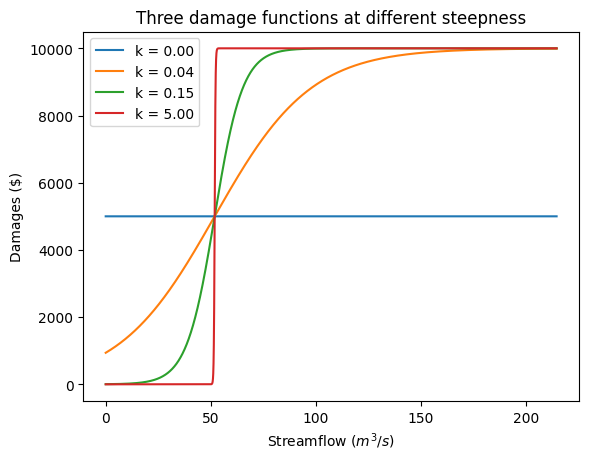

In [6]:
for k in select_ks:
    streamflow_damages[k].plot(label='k = %.2f' % k)
plt.title('Three damage functions at different steepness')
plt.xlabel(r'Streamflow ($m^3/s$)')
plt.ylabel('Damages ($)')
plt.legend()

# Value diagram for three damage functions

## Define decision context

In [7]:
decision_context = {
    'utility_function': [cara, {'A': adjusted_risk_aversion}],
    'decision_rule': [optimise_over_forecast_distribution, None],
    'decision_thresholds': None,
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'damage_function': [logistic, {'k': None, 'A': max_damages, 'threshold': damages_threshold}]
}

## Calculate RUV

In [8]:
results = pd.DataFrame(index=alphas, columns=select_ks)
for k in select_ks:
    print('Calculating RUV for steepness parameter %.2f' % k)
    decision_context['damage_function'][1]['k'] = k
    results[k] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']    

Calculating RUV for steepness parameter 0.00
Calculating RUV for steepness parameter 0.04
Calculating RUV for steepness parameter 0.15
Calculating RUV for steepness parameter 5.00


## Plot results

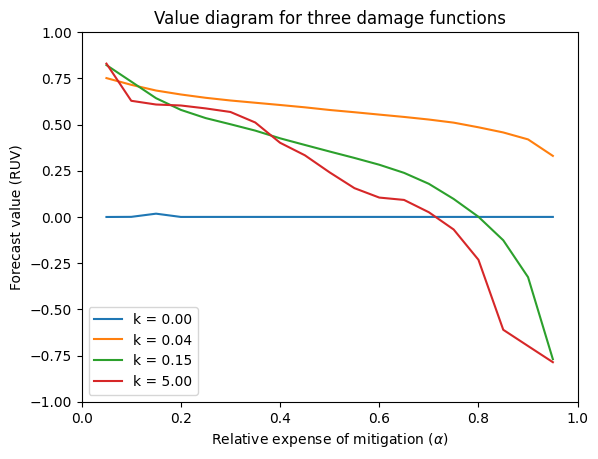

In [9]:
for k in select_ks:
    results[k].plot(label='k = %.2f' % k)
plt.title('Value diagram for three damage functions')
plt.xlabel(r'Relative expense of mitigation ($\alpha$)')
plt.ylabel('Forecast value (RUV)')
plt.ylim(-1, 1)
plt.xlim(0, 1)
plt.legend()

# Value for damage functions of varying location

## Define decision context

In [10]:
decision_context = {
    'utility_function': [cara, {'A': adjusted_risk_aversion}],
    'decision_rule': [optimise_over_forecast_distribution, None],
    'decision_thresholds': None,
    'economic_model': [cost_loss, cost_loss_analytical_spend, select_alphas],
    'damage_function': [logistic, {'k': None, 'A': max_damages, 'threshold': damages_threshold}]
}

## Calculate RUV

In [11]:
results = pd.DataFrame(index=ks, columns=select_alphas)
for k in ks:
    print('Calculating RUV for steepness parameter %.4f' % k)
    decision_context['damage_function'][1]['k'] = k
    results.loc[k] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

Calculating RUV for steepness parameter 0.0000
Calculating RUV for steepness parameter 0.0018
Calculating RUV for steepness parameter 0.0038
Calculating RUV for steepness parameter 0.0058
Calculating RUV for steepness parameter 0.0079
Calculating RUV for steepness parameter 2.5932
Calculating RUV for steepness parameter 2.7280
Calculating RUV for steepness parameter 2.8697
Calculating RUV for steepness parameter 3.0186
Calculating RUV for steepness parameter 3.1752
Calculating RUV for steepness parameter 3.3398
Calculating RUV for steepness parameter 3.5129
Calculating RUV for steepness parameter 3.6948
Calculating RUV for steepness parameter 3.8861
Calculating RUV for steepness parameter 4.0872
Calculating RUV for steepness parameter 4.2986
Calculating RUV for steepness parameter 4.5208
Calculating RUV for steepness parameter 4.7544
Calculating RUV for steepness parameter 5.0000


## Plot results

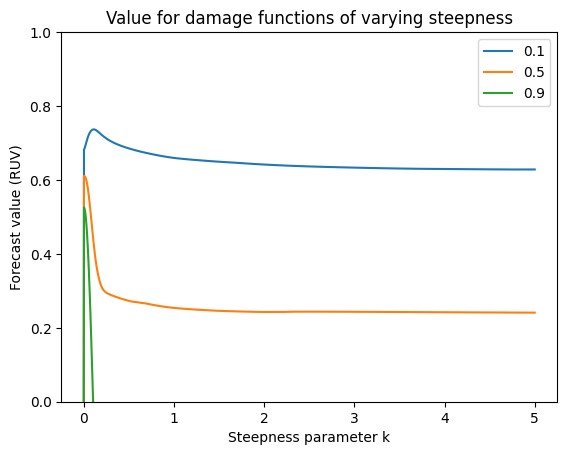

In [12]:
results.plot()
plt.title('Value for damage functions of varying steepness')
plt.xlabel(r'Steepness parameter k')
plt.ylabel('Forecast value (RUV)')
plt.ylim(0, 1)
plt.legend()